In [98]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from multiprocessing import Pool, cpu_count
import os
import time

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
#import sbi_tools
import plot_utils
#import scripts
# from scripts import sbi_tools
#from scripts import plot_utils
#import generate_emuPks as genP

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
dir_mocks = '../data/cosmolib/'

In [100]:
idx_LH = 0

In [101]:
param_names = ['omega_cold', 'sigma_8',  'h', 'omega_baryon', 'n_s', 'seed']
param_vals = np.loadtxt(f'{dir_mocks}/LH{idx_LH}/cosmo_{idx_LH}.txt')
param_dict = dict(zip(param_names, param_vals))
print(param_dict)

{'omega_cold': 0.2775274936564327, 'sigma_8': 0.7049140324569382, 'h': 0.7241123952301097, 'omega_baryon': 0.049, 'n_s': 0.9624, 'seed': 0.0}


In [102]:
bias_terms_eul = np.load(f'{dir_mocks}/LH{idx_LH}/Eulerian_fields_lr_{idx_LH}.npy')
print(bias_terms_eul.shape)
for i in range(bias_terms_eul.shape[0]):
    print(np.min(bias_terms_eul[i]), np.max(bias_terms_eul[i]))

(5, 128, 128, 128)
-708.9023 3009.281
-1313.885 4600.993
-2288.3235 7788.8594
-845.49646 1074.5205
-158.66951 86.10809


In [103]:
n_grid = bias_terms_eul.shape[-1]

In [104]:
norm=n_grid**3
bias_terms_eul_norm = bias_terms_eul/norm

In [105]:
bias_vector = [1., 0., 0., 0.]

In [106]:
def sum_bias_fields(fields, bias_vector):
    bias_vector_extended = np.concatenate(([1.0], bias_vector))
    return np.sum(fields*bias_vector_extended)

In [107]:
#bias_terms_eul_0_norm = bias_terms_eul[0]/512**3
tracer_field_eul = bacco.utils.sum_bias_model_terms_py(zeroth=bias_terms_eul[0], 
                                            first=bias_terms_eul[1],
                                            second=bias_terms_eul[2], 
                                            tidal=bias_terms_eul[3], 
                                            laplacian=bias_terms_eul[4], 
                                            b1=bias_vector[0], b2=bias_vector[1], b3=bias_vector[2], 
                                            b4=bias_vector[3], ngrid=128)

tracer_field_eul_norm = tracer_field_eul/np.mean(tracer_field_eul)
tracer_field_eul_norm128 = tracer_field_eul/128**3
tracer_field_eul_norm512 = tracer_field_eul/512**3

In [108]:
bias_vector_b1is0 = [0., 0., 0., 0.]
tracer_field_eul_b1is0 = bacco.utils.sum_bias_model_terms_py(zeroth=bias_terms_eul[0], 
                                            first=bias_terms_eul[1],
                                            second=bias_terms_eul[2], 
                                            tidal=bias_terms_eul[3], 
                                            laplacian=bias_terms_eul[4], 
                                            b1=bias_vector_b1is0[0], b2=bias_vector_b1is0[1], b3=bias_vector_b1is0[2], 
                                            b4=bias_vector_b1is0[3], ngrid=128)

tracer_field_eul_b1is0_norm = tracer_field_eul_b1is0/np.mean(tracer_field_eul_b1is0)
tracer_field_eul_b1is0_norm128 = tracer_field_eul_b1is0/128**3
tracer_field_eul_b1is0_norm512 = tracer_field_eul_b1is0/512**3

In [109]:
np.mean(tracer_field_eul), np.mean(tracer_field_eul_b1is0)

(64.000015, 63.999996)

In [150]:
print(tracer_field_eul.shape, np.min(tracer_field_eul), np.max(tracer_field_eul))
print(tracer_field_eul_norm.shape, np.min(tracer_field_eul_norm), np.max(tracer_field_eul_norm))
print(tracer_field_eul_norm128.shape, np.min(tracer_field_eul_norm128), np.max(tracer_field_eul_norm128))
print(tracer_field_eul_norm512.shape, np.min(tracer_field_eul_norm512), np.max(tracer_field_eul_norm512))

(128, 128, 128) -2022.7874 7610.2744
(128, 128, 128) -31.606045 118.91051
(128, 128, 128) -0.0009645401732996106 0.0036288616247475147
(128, 128, 128) -1.507094e-05 5.6700963e-05


(128, 128) -944.54004 4016.366


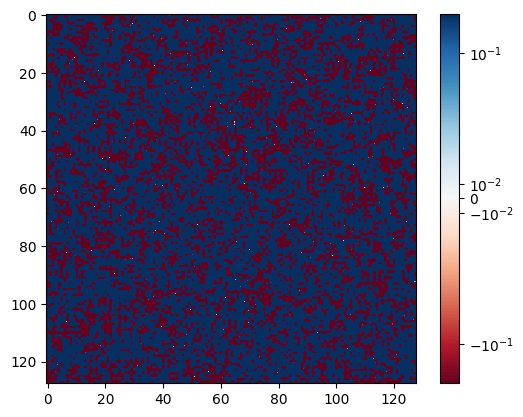

In [111]:
 # Set normalisation
from matplotlib.colors import SymLogNorm
norm = SymLogNorm(
        linthresh=0.01, linscale=0.1, 
        #linthresh=0.001, linscale=0.001, 
        vmin=-0.2, vmax=0.2
        )

field_2d = tracer_field_eul[2,:,:]
print(field_2d.shape, np.min(field_2d), np.max(field_2d))

plt.imshow(field_2d, norm=norm, cmap='RdBu')
plt.colorbar()
plt.show()

In [112]:
a_scale = 1
cosmopars = dict(
        omega_cdm=param_dict['omega_cold'],
        omega_baryon=param_dict['omega_baryon'],
        hubble=param_dict['h'],
        ns=param_dict['n_s'],
        sigma8=param_dict['sigma_8'],
        tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
    )

cosmo = bacco.Cosmology(**cosmopars)
cosmo.set_expfactor(a_scale)

2024-02-20 18:04:19,439 bacco.cosmo :    initialization took 0.000 secs


In [113]:
box_size = 1000

k_min = 0.01
k_max = 1
n_bins = 30
log_binning = True

In [114]:
args_power = {'ngrid':n_grid,
            'box':box_size,
            'cosmology':cosmo,
            'interlacing':False,
            'kmin':k_min,
            'kmax':k_max,
            'nbins':n_bins,
            'correct_grid':True,
            'log_binning':log_binning,
            'deposit_method':'cic',
            'compute_correlation':False,
            'zspace':False,
            'compute_power2d':False}

In [115]:
pk = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=tracer_field_eul,
                        grid2=tracer_field_eul,
                        normalise_grid1=True,
                        normalise_grid2=True,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)

2024-02-20 18:04:21,585 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-02-20 18:04:21,711 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.124 secs
2024-02-20 18:04:21,842 bacco.cosmo :    created Pk(z=0) tab from k 6.905005284352228e-05 to 100000.0 h/Mpc
2024-02-20 18:04:21,937 bacco.cosmo :    computed halofit at z=0.00 for 'Default' in 0.002 secs


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.071541 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.380687 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000152 secs
bacco.power : Deallocating arrays


2024-02-20 18:04:22,572 bacco.statistics :  ...done in 0.986 s


In [116]:
pk_norm128 = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=tracer_field_eul_norm128,
                        grid2=tracer_field_eul_norm128,
                        normalise_grid1=True,
                        normalise_grid2=True,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)

2024-02-20 18:04:23,241 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 64 (grid1) 64 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.088151 sec
bacco.power : Counting modes


2024-02-20 18:04:23,875 bacco.statistics :  ...done in 0.634 s


bacco.power : done counting modes in 0.424412 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000421 secs
bacco.power : Deallocating arrays


In [117]:
pk_norm128_normgridfalse = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=tracer_field_eul_norm128,
                        grid2=tracer_field_eul_norm128,
                        normalise_grid1=False,
                        normalise_grid2=False,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)

2024-02-20 18:04:24,631 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 64 (grid1) 64 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.108012 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.384710 sec


2024-02-20 18:04:25,196 bacco.statistics :  ...done in 0.565 s


bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000411 secs
bacco.power : Deallocating arrays


In [152]:
pk_norm512_normgridfalse = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=tracer_field_eul_norm512,
                        grid2=tracer_field_eul_norm512,
                        normalise_grid1=False,
                        normalise_grid2=False,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)

2024-02-20 18:27:43,940 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.044231 sec
bacco.power : Counting modes


2024-02-20 18:27:44,310 bacco.statistics :  ...done in 0.37 s


bacco.power : done counting modes in 0.293732 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000445 secs
bacco.power : Deallocating arrays


In [118]:
pk_normgridfalse = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=tracer_field_eul,
                        grid2=tracer_field_eul,
                        normalise_grid1=False,
                        normalise_grid2=False,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)
print(pk_normgridfalse['pk'])

2024-02-20 18:04:25,742 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.120269 sec
bacco.power : Counting modes


2024-02-20 18:04:26,232 bacco.statistics :  ...done in 0.49 s


bacco.power : done counting modes in 0.337652 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000420 secs
bacco.power : Deallocating arrays
[1.81014034e+21 2.10315865e+21 1.36909297e+21 1.56118311e+21
 2.54282428e+21 1.48913904e+21 1.43826475e+21 1.13905793e+21
 9.68676721e+20 7.42190954e+20 6.87571861e+20 6.55455799e+20
 5.57835176e+20 4.31106464e+20 3.24359299e+20 2.79648899e+20
 2.33277815e+20 1.81063950e+20 1.52338688e+20 1.20494560e+20
 9.99804579e+19 8.15229495e+19 6.75455097e+19 5.55876065e+19
 4.55632372e+19 3.66570112e+19 2.81421079e+19 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [119]:
pk_b1is0_normgridfalse = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=tracer_field_eul_b1is0,
                        grid2=tracer_field_eul_b1is0,
                        normalise_grid1=False,
                        normalise_grid2=False,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)
print(pk_b1is0_normgridfalse['pk'])

2024-02-20 18:04:26,867 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.057274 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.320482 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000410 secs
bacco.power : Deallocating arrays


2024-02-20 18:04:27,280 bacco.statistics :  ...done in 0.413 s


[4.44778660e+20 5.18550257e+20 3.34496796e+20 3.82352297e+20
 6.23298675e+20 3.62907591e+20 3.51986441e+20 2.76980170e+20
 2.33775044e+20 1.78858275e+20 1.65104673e+20 1.56912863e+20
 1.32299141e+20 1.00768980e+20 7.48158999e+19 6.36566598e+19
 5.21948465e+19 3.94328914e+19 3.24308771e+19 2.48761620e+19
 2.00343599e+19 1.57637394e+19 1.25883179e+19 9.94133327e+18
 7.76302118e+18 5.97954745e+18 4.40196764e+18 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [120]:
pk_norm512_normgridfalse = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=tracer_field_eul_norm512,
                        grid2=tracer_field_eul_norm512,
                        normalise_grid1=False,
                        normalise_grid2=False,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)

2024-02-20 18:04:27,977 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0


2024-02-20 18:04:28,390 bacco.statistics :  ...done in 0.413 s


bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.051247 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.307960 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000189 secs
bacco.power : Deallocating arrays


In [121]:
pk_b1is0_norm512_normgridfalse = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=tracer_field_eul_b1is0_norm512,
                        grid2=tracer_field_eul_b1is0_norm512,
                        normalise_grid1=False,
                        normalise_grid2=False,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)

2024-02-20 18:04:29,041 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.025916 sec
bacco.power : Counting modes


2024-02-20 18:04:29,447 bacco.statistics :  ...done in 0.405 s


bacco.power : done counting modes in 0.298966 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000161 secs
bacco.power : Deallocating arrays


In [122]:
pk_nonorm = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=tracer_field_eul,
                        grid2=tracer_field_eul,
                        normalise_grid1=True,
                        normalise_grid2=True,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)

2024-02-20 18:04:30,069 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.046003 sec
bacco.power : Counting modes


2024-02-20 18:04:30,484 bacco.statistics :  ...done in 0.415 s


bacco.power : done counting modes in 0.325895 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000569 secs
bacco.power : Deallocating arrays


In [123]:
pk_b1is0 = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=tracer_field_eul_b1is0,
                        grid2=tracer_field_eul_b1is0,
                        normalise_grid1=True,
                        normalise_grid2=True,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)

2024-02-20 18:04:31,112 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.061706 sec
bacco.power : Counting modes


2024-02-20 18:04:31,536 bacco.statistics :  ...done in 0.424 s


bacco.power : done counting modes in 0.327585 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000170 secs
bacco.power : Deallocating arrays


In [124]:
tracer_field_eul_norm512 = tracer_field_eul/512**3.
pk_norm512 = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=tracer_field_eul_norm512,
                        grid2=tracer_field_eul_norm512,
                        normalise_grid1=False,
                        normalise_grid2=False,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)

2024-02-20 18:04:32,213 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.027105 sec
bacco.power : Counting modes


2024-02-20 18:04:32,564 bacco.statistics :  ...done in 0.35 s


bacco.power : done counting modes in 0.292813 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000152 secs
bacco.power : Deallocating arrays


In [125]:
lt_k = np.logspace(np.log10(np.pi / box_size), np.log10(2 * np.pi / box_size * n_grid), num=90)
pk_lpt = bacco.utils.compute_pt_15_basis_terms(cosmo, expfactor=cosmo.expfactor, wavemode=lt_k)

In [126]:
np.min(bias_terms_eul[0]), np.max(bias_terms_eul[0])

(-708.9023, 3009.281)

In [127]:
bias_terms_eul_norm512 = bias_terms_eul / 512**3
#bias_terms_eul_norm[0] /= 512**(3)

In [128]:
pk_11_norm512 = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=bias_terms_eul_norm512[0],
                        grid2=bias_terms_eul_norm512[0],
                        normalise_grid1=True,
                        normalise_grid2=True,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)

2024-02-20 18:04:36,740 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.054271 sec
bacco.power : Counting modes


2024-02-20 18:04:37,161 bacco.statistics :  ...done in 0.421 s


bacco.power : done counting modes in 0.305693 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000284 secs
bacco.power : Deallocating arrays


In [129]:
pk_dd_norm512 = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=bias_terms_eul_norm512[1],
                        grid2=bias_terms_eul_norm512[1],
                        normalise_grid1=True,
                        normalise_grid2=True,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)

2024-02-20 18:04:37,752 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -9.83972e-11 (grid1) -9.83972e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.057519 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.292028 sec


2024-02-20 18:04:38,160 bacco.statistics :  ...done in 0.408 s


bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000622 secs
bacco.power : Deallocating arrays


In [130]:
pk_dd_nonorm = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=bias_terms_eul[1],
                        grid2=bias_terms_eul[1],
                        normalise_grid1=False,
                        normalise_grid2=False,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)

2024-02-20 18:04:38,800 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -0.0132066 (grid1) -0.0132066 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.065410 sec
bacco.power : Counting modes


2024-02-20 18:04:39,223 bacco.statistics :  ...done in 0.423 s


bacco.power : done counting modes in 0.330549 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000149 secs
bacco.power : Deallocating arrays


In [131]:
bias_terms_eul_norm128 = bias_terms_eul / 128**3
pk_dd_norm128 = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=bias_terms_eul_norm128[1],
                        grid2=bias_terms_eul_norm128[1],
                        normalise_grid1=False,
                        normalise_grid2=False,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)

2024-02-20 18:04:39,924 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -6.29742e-09 (grid1) -6.29742e-09 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.024276 sec
bacco.power : Counting modes


2024-02-20 18:04:40,365 bacco.statistics :  ...done in 0.441 s


bacco.power : done counting modes in 0.331190 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.012845 secs
bacco.power : Deallocating arrays


In [154]:

#Compute a dummy variable with the 15 combinations of 5 distinct objects
import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(bias_terms_eul.shape[0]),r=2)))

#Compute the P(k) of the 15 terms
power_all_terms_pred = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power['correct_grid'] = False if ii == 11 else True

    power_term_pred = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_norm512[prod[ii,0]],
                                                    grid2=bias_terms_eul_norm512[prod[ii,1]],
                                                    normalise_grid1=False,
                                                    normalise_grid2=False,
                                                    deconvolve_grid1=False,
                                                    deconvolve_grid2=False,
                                                    **args_power)
    power_all_terms_pred.append(power_term_pred)


2024-02-20 18:30:31,038 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.021416 sec
bacco.power : Counting modes


2024-02-20 18:30:31,454 bacco.statistics :  ...done in 0.416 s
2024-02-20 18:30:31,458 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.328572 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000410 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) -9.83972e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.043318 sec
bacco.power : Counting modes


2024-02-20 18:30:31,879 bacco.statistics :  ...done in 0.422 s
2024-02-20 18:30:31,880 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.329643 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000426 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) -8.04241e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.035164 sec
bacco.power : Counting modes


2024-02-20 18:30:32,263 bacco.statistics :  ...done in 0.383 s
2024-02-20 18:30:32,273 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.289709 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000207 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 8.03671e-07 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.040466 sec
bacco.power : Counting modes


2024-02-20 18:30:32,684 bacco.statistics :  ...done in 0.411 s
2024-02-20 18:30:32,685 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.305611 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000614 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 6.07881e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.041570 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.297549 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000532 secs
bacco.power : Deallocating arrays


2024-02-20 18:30:33,094 bacco.statistics :  ...done in 0.41 s
2024-02-20 18:30:33,095 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -9.83972e-11 (grid1) -9.83972e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.010754 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.324026 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000200 secs
bacco.power : Deallocating arrays


2024-02-20 18:30:33,517 bacco.statistics :  ...done in 0.422 s
2024-02-20 18:30:33,518 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -9.83972e-11 (grid1) -8.04241e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.045673 sec
bacco.power : Counting modes


2024-02-20 18:30:33,965 bacco.statistics :  ...done in 0.447 s
2024-02-20 18:30:33,966 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.303868 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000328 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -9.83972e-11 (grid1) 8.03671e-07 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.059829 sec
bacco.power : Counting modes


2024-02-20 18:30:34,393 bacco.statistics :  ...done in 0.427 s
2024-02-20 18:30:34,394 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.294001 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000237 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0


2024-02-20 18:30:34,815 bacco.statistics :  ...done in 0.421 s
2024-02-20 18:30:34,816 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : total mass -9.83972e-11 (grid1) 6.07881e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.037333 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.300222 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000621 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -8.04241e-06 (grid1) -8.04241e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.046537 sec
bacco.power : Counting modes


2024-02-20 18:30:35,253 bacco.statistics :  ...done in 0.437 s
2024-02-20 18:30:35,254 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.314829 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000149 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -8.04241e-06 (grid1) 8.03671e-07 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.009675 sec
bacco.power : Counting modes


2024-02-20 18:30:35,648 bacco.statistics :  ...done in 0.394 s
2024-02-20 18:30:35,649 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.293291 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000222 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -8.04241e-06 (grid1) 6.07881e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.047767 sec
bacco.power : Counting modes


2024-02-20 18:30:36,052 bacco.statistics :  ...done in 0.403 s
2024-02-20 18:30:36,053 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.313528 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000593 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 8.03671e-07 (grid1) 8.03671e-07 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.047524 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.299169 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000332 secs
bacco.power : Deallocating arrays


2024-02-20 18:30:36,445 bacco.statistics :  ...done in 0.392 s
2024-02-20 18:30:36,446 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 8.03671e-07 (grid1) 6.07881e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.053173 sec
bacco.power : Counting modes


2024-02-20 18:30:36,879 bacco.statistics :  ...done in 0.433 s
2024-02-20 18:30:36,880 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.340171 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000441 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 6.07881e-11 (grid1) 6.07881e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.046223 sec
bacco.power : Counting modes


2024-02-20 18:30:37,341 bacco.statistics :  ...done in 0.462 s


bacco.power : done counting modes in 0.357699 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000410 secs
bacco.power : Deallocating arrays


In [155]:
bias_extended = np.concatenate([[1], bias_vector])

prod = np.array(list(itertools.combinations_with_replacement(np.arange(5), r=2)))

sum_terms_power = 0
for ii in range(0,15):
    fac = 2 if prod[ii,0]!=prod[ii,1] else 1
    sum_terms_power += bias_extended[prod[ii,0]] * bias_extended[prod[ii,1]] * power_all_terms_pred[ii]['pk'] * fac

In [141]:

#Compute a dummy variable with the 15 combinations of 5 distinct objects
import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(bias_terms_eul.shape[0]),r=2)))

#Compute the P(k) of the 15 terms
power_all_terms_pred_nonorm_normgrid = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power['correct_grid'] = False if ii == 11 else True

    power_term_pred = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul[prod[ii,0]],
                                                    grid2=bias_terms_eul[prod[ii,1]],
                                                    normalise_grid1=True,
                                                    normalise_grid2=True,
                                                    deconvolve_grid1=False,
                                                    deconvolve_grid2=False,
                                                    **args_power)
    power_all_terms_pred_nonorm_normgrid.append(power_term_pred)


2024-02-20 18:09:09,135 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.047050 sec
bacco.power : Counting modes


2024-02-20 18:09:09,565 bacco.statistics :  ...done in 0.431 s
2024-02-20 18:09:09,566 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.325900 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.012718 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0


2024-02-20 18:09:09,968 bacco.statistics :  ...done in 0.402 s
2024-02-20 18:09:09,969 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) -0.0132066 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.047714 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.322366 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000144 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) -1079.43 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.055478 sec
bacco.power : Counting modes


2024-02-20 18:09:10,386 bacco.statistics :  ...done in 0.417 s
2024-02-20 18:09:10,387 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.321021 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000451 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 107.867 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.046234 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.310088 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000147 secs
bacco.power : Deallocating arrays


2024-02-20 18:09:10,774 bacco.statistics :  ...done in 0.387 s
2024-02-20 18:09:10,774 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 0.00815884 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.047604 sec
bacco.power : Counting modes


2024-02-20 18:09:11,195 bacco.statistics :  ...done in 0.42 s
2024-02-20 18:09:11,196 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.327778 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000413 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -0.0132066 (grid1) -0.0132066 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.062561 sec
bacco.power : Counting modes


2024-02-20 18:09:11,606 bacco.statistics :  ...done in 0.409 s
2024-02-20 18:09:11,607 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.316866 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000142 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -0.0132066 (grid1) -1079.43 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.061229 sec
bacco.power : Counting modes


2024-02-20 18:09:11,992 bacco.statistics :  ...done in 0.385 s
2024-02-20 18:09:11,993 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.295802 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000438 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -0.0132066 (grid1) 107.867 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.061267 sec
bacco.power : Counting modes


2024-02-20 18:09:12,475 bacco.statistics :  ...done in 0.482 s
2024-02-20 18:09:12,482 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.374509 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000312 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -0.0132066 (grid1) 0.00815884 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.054046 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.322716 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000306 secs
bacco.power : Deallocating arrays


2024-02-20 18:09:12,918 bacco.statistics :  ...done in 0.435 s
2024-02-20 18:09:12,919 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -1079.43 (grid1) -1079.43 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.062646 sec
bacco.power : Counting modes


2024-02-20 18:09:13,362 bacco.statistics :  ...done in 0.443 s
2024-02-20 18:09:13,363 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.332282 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000312 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -1079.43 (grid1) 107.867 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.077221 sec
bacco.power : Counting modes


2024-02-20 18:09:13,796 bacco.statistics :  ...done in 0.433 s
2024-02-20 18:09:13,797 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.305555 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.012226 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -1079.43 (grid1) 0.00815884 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.065450 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.333731 sec
bacco.power : Starting Fourier loop 

2024-02-20 18:09:14,232 bacco.statistics :  ...done in 0.435 s
2024-02-20 18:09:14,232 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False



bacco.power : done Fourier loop in 0.000421 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 107.867 (grid1) 107.867 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.063597 sec
bacco.power : Counting modes


2024-02-20 18:09:14,643 bacco.statistics :  ...done in 0.41 s
2024-02-20 18:09:14,643 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.314887 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000177 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 107.867 (grid1) 0.00815884 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.044361 sec
bacco.power : Counting modes


2024-02-20 18:09:15,099 bacco.statistics :  ...done in 0.455 s
2024-02-20 18:09:15,099 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.341621 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000385 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00815884 (grid1) 0.00815884 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.067257 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.320975 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000435 secs
bacco.power : Deallocating arrays


2024-02-20 18:09:15,512 bacco.statistics :  ...done in 0.413 s


In [142]:
bias_extended = np.concatenate([[1], bias_vector])

prod = np.array(list(itertools.combinations_with_replacement(np.arange(5), r=2)))

sum_terms_power_nonorm_normgrid = 0
for ii in range(0,15):
    fac = 2 if prod[ii,0]!=prod[ii,1] else 1
    sum_terms_power_nonorm_normgrid += bias_extended[prod[ii,0]] * bias_extended[prod[ii,1]] * power_all_terms_pred_nonorm_normgrid[ii]['pk'] * fac

In [134]:
bias_terms_eul_mixnorm = bias_terms_eul.copy()
bias_terms_eul_mixnorm[0] /= 512^3

In [135]:

#Compute a dummy variable with the 15 combinations of 5 distinct objects
import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(bias_terms_eul.shape[0]),r=2)))

#Compute the P(k) of the 15 terms
power_all_terms_pred_mixnorm = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power['correct_grid'] = False if ii == 11 else True

    if prod[ii][0]==0 and prod[ii][1]==0:
        grid1 = bias_terms_eul_norm512[prod[ii,0]]
        grid2 = bias_terms_eul_norm512[prod[ii,1]]
    else:
        grid1 = bias_terms_eul[prod[ii,0]]
        grid2 = bias_terms_eul[prod[ii,1]]
    power_term_pred_mixnorm = bacco.statistics.compute_crossspectrum_twogrids(grid1=grid1,
                                                    grid2=grid2,
                                                    normalise_grid1=True,
                                                    normalise_grid2=True,
                                                    deconvolve_grid1=False,
                                                    deconvolve_grid2=False,
                                                    **args_power)
    power_all_terms_pred_mixnorm.append(power_term_pred_mixnorm)


2024-02-20 18:04:50,295 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.047597 sec
bacco.power : Counting modes


2024-02-20 18:04:50,754 bacco.statistics :  ...done in 0.459 s
2024-02-20 18:04:50,755 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.314684 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000160 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) -0.0132066 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.035399 sec
bacco.power : Counting modes


2024-02-20 18:04:51,156 bacco.statistics :  ...done in 0.401 s
2024-02-20 18:04:51,160 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.326586 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000164 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) -1079.43 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.053363 sec
bacco.power : Counting modes


2024-02-20 18:04:51,545 bacco.statistics :  ...done in 0.385 s
2024-02-20 18:04:51,545 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.304953 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000148 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 107.867 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.055629 sec
bacco.power : Counting modes


2024-02-20 18:04:51,932 bacco.statistics :  ...done in 0.386 s
2024-02-20 18:04:51,940 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.280066 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000465 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 0.00815884 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.084737 sec
bacco.power : Counting modes


2024-02-20 18:04:52,392 bacco.statistics :  ...done in 0.452 s
2024-02-20 18:04:52,392 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.326760 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000157 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -0.0132066 (grid1) -0.0132066 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.035544 sec
bacco.power : Counting modes


2024-02-20 18:04:52,839 bacco.statistics :  ...done in 0.447 s
2024-02-20 18:04:52,839 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.329465 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000150 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -0.0132066 (grid1) -1079.43 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.058784 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.330538 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000534 secs
bacco.power : Deallocating arrays


2024-02-20 18:04:53,273 bacco.statistics :  ...done in 0.434 s
2024-02-20 18:04:53,280 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0


2024-02-20 18:04:53,660 bacco.statistics :  ...done in 0.38 s
2024-02-20 18:04:53,667 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -0.0132066 (grid1) 107.867 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.054946 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.294688 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000567 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -0.0132066 (grid1) 0.00815884 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.044208 sec
bacco.power : Counting modes


2024-02-20 18:04:54,037 bacco.statistics :  ...done in 0.37 s
2024-02-20 18:04:54,038 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.298621 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000524 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -1079.43 (grid1) -1079.43 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.061328 sec
bacco.power : Counting modes


2024-02-20 18:04:54,423 bacco.statistics :  ...done in 0.385 s
2024-02-20 18:04:54,424 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.296722 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000594 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -1079.43 (grid1) 107.867 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.038029 sec
bacco.power : Counting modes


2024-02-20 18:04:54,828 bacco.statistics :  ...done in 0.404 s
2024-02-20 18:04:54,829 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.330422 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000164 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -1079.43 (grid1) 0.00815884 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.060529 sec
bacco.power : Counting modes


2024-02-20 18:04:55,218 bacco.statistics :  ...done in 0.389 s
2024-02-20 18:04:55,219 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.289262 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000155 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 107.867 (grid1) 107.867 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.037392 sec
bacco.power : Counting modes


2024-02-20 18:04:55,631 bacco.statistics :  ...done in 0.412 s
2024-02-20 18:04:55,644 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.342741 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000266 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 107.867 (grid1) 0.00815884 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.062127 sec
bacco.power : Counting modes


2024-02-20 18:04:56,099 bacco.statistics :  ...done in 0.455 s
2024-02-20 18:04:56,105 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.321692 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000291 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00815884 (grid1) 0.00815884 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.099614 sec
bacco.power : Counting modes


2024-02-20 18:04:56,595 bacco.statistics :  ...done in 0.49 s


bacco.power : done counting modes in 0.334822 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000412 secs
bacco.power : Deallocating arrays


In [136]:
bias_extended = np.concatenate([[1], bias_vector])

prod = np.array(list(itertools.combinations_with_replacement(np.arange(5), r=2)))

sum_terms_power_mixnorm = 0
for ii in range(0,15):
    fac = 2 if prod[ii,0]!=prod[ii,1] else 1
    sum_terms_power_mixnorm += bias_extended[prod[ii,0]] * bias_extended[prod[ii,1]] * power_all_terms_pred_mixnorm[ii]['pk'] * fac

Text(0, 0.5, '$P(k) \\,\\, [h^{-3} \\,\\, {\\rm Mpc}^3]$')

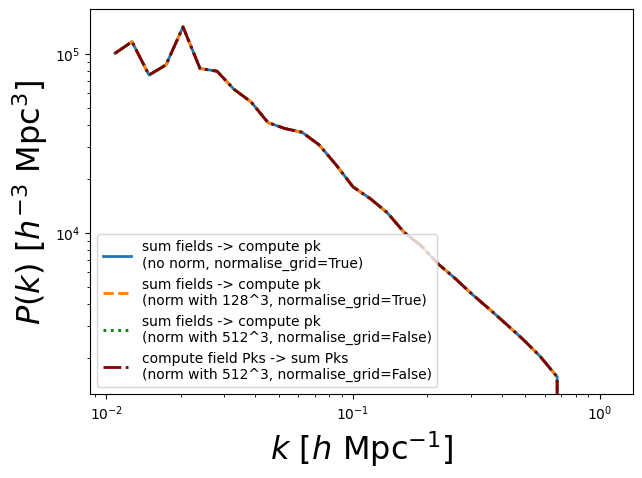

In [159]:
plt.figure(figsize=(7,5))
ax = plt.gca()
ax.loglog(pk['k'], pk['pk'], label='sum fields -> compute pk \n(no norm, normalise_grid=True)', lw=2)
ax.loglog(pk_norm128['k'], pk_norm128['pk'], label='sum fields -> compute pk \n(norm with 128^3, normalise_grid=True)', ls='--', lw=2)
#ax.loglog(pk_normgridfalse['k'], pk_normgridfalse['pk'], 
#           label='sum fields -> compute pk \n(no norm, normalise_grid=False)', ls='-.', color='purple', lw=2)
# ax.loglog(pk_norm128_normgridfalse['k'], pk_norm128_normgridfalse['pk'], 
#           label='sum fields -> compute pk \n(norm with 128^3, normalise_grid=False)', ls=':', color='magenta', lw=2)
ax.loglog(pk_norm512_normgridfalse['k'], pk_norm512_normgridfalse['pk'], 
          label='sum fields -> compute pk \n(norm with 512^3, normalise_grid=False)', ls=':', color='green', lw=2)

#ax.loglog(pk_norm128_normgridfalse['k'], pk_norm128_normgridfalse['pk'], label='combine fields -> compute pk \n(norm with 128^2, normalise_grid=False)', lw=2)
#ax.loglog(pk_norm512['k'], pk_norm512['pk'], label='combine fields -> compute pk \n(norm with 512^3, normalise_grid=False)', ls='--', color='cyan', lw=2)
ax.loglog(pk['k'], sum_terms_power, label='compute field Pks -> sum Pks \n(norm with 512^3, normalise_grid=False)', ls='-.', lw='2', color='maroon')
#ax.loglog(pk['k'], sum_terms_power_nonorm_normgrid, label='compute field Pks -> sum Pks \n(no norm, normalise_grid=True)', ls='-.', lw='2')
#ax.loglog(pk['k'], sum_terms_power_mixnorm, label='compute field Pks -> sum Pks \n(11 norm with 512^3, others no norm, normalise_grid=True)', ls=':', lw='2')


plt.legend()

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

Text(0, 0.5, '$P(k) \\,\\, [h^{-3} \\,\\, {\\rm Mpc}^3]$')

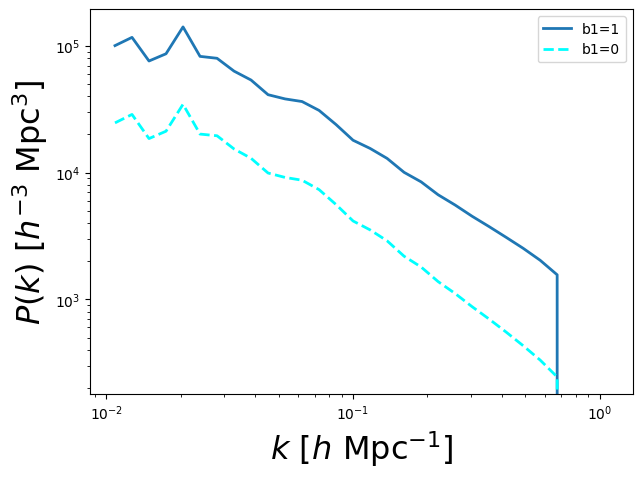

In [138]:
plt.figure(figsize=(7,5))
ax = plt.gca()
ax.loglog(pk_norm512_normgridfalse['k'], pk_norm512_normgridfalse['pk'], label='b1=1', lw=2)
ax.loglog(pk_b1is0_norm512_normgridfalse['k'], pk_b1is0_norm512_normgridfalse['pk'], label='b1=0', 
          ls='--', color='cyan', lw=2)

plt.legend()

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

Text(0, 0.5, '$P(k) \\,\\, [h^{-3} \\,\\, {\\rm Mpc}^3]$')

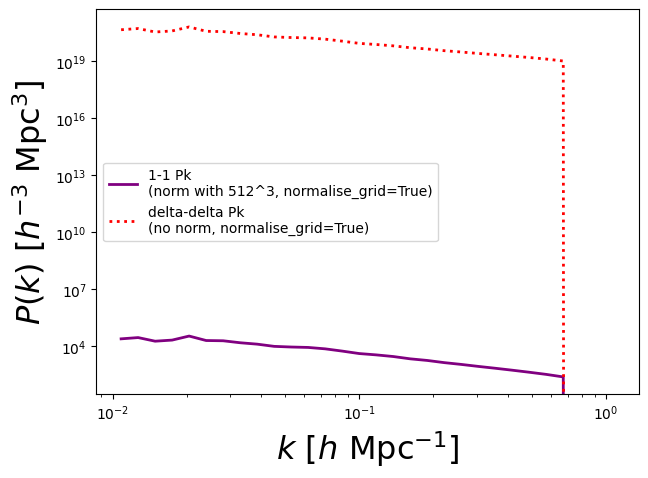

In [139]:
plt.figure(figsize=(7,5))
ax = plt.gca()

ax.loglog(pk_11_norm512['k'], pk_11_norm512['pk'], label='1-1 Pk \n(norm with 512^3, normalise_grid=True)', ls='-', color='purple', lw=2)
#ax.loglog(pk_dd_norm512['k'], pk_dd_norm512['pk'], label='delta-delta Pk \n(norm with 512^3, normalise_grid=True)', ls='--', color='magenta', lw=2)
ax.loglog(pk_dd_nonorm['k'], pk_dd_nonorm['pk'], label='delta-delta Pk \n(no norm, normalise_grid=True)', ls=':', color='red', lw=2)


plt.legend()

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)